# Solving CartPole-v0 with the Vanilla Policy Gradient algorithm

The following is an implementation of the  Vanilla Policy Gradient (VPG) also known as REINFORCE with baseline. 

REINFORCE was improved to use a baseline to avoid the large variance due to the Monte carlo targets. 

```The accumulation of random events along a trajectory, including the initial state sampled from the initial state distribution, transition function probabilities, but now in this chapter with stochastic policies, the randomness action selection adds to the mix. All this randomness is compounded inside the return, making it a high-variance signal challenging to interpret.``` [__Grokking Deep Reinforcement learning__](https://livebook.manning.com/book/grokking-deep-reinforcement-learning/chapter-11/v-14/point-8971-43-43-0)

To get around this we will look at how big an advantage an action has over the others. To do this we will need a value function, that estimates the value of the current state. The advantage can then be calculated as the actual return - the value of the state. Using the advantage will create feedback which is more or less centered around zero, and it therefore better to train your agent. 

The environment Cartpole-v0 is used to test the algorithm, was created by OpenAi and is described in more detail here [cartpolev0]() and here [doc]().

If the algorithm manages to execute the simulation of the cartpole for a 100 episodes, keeping it balanced for more then 195 steps the environment is said to be solved.

In [1]:
import numpy as np
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm

In [2]:
def print_step(state, reward, done, info):
    print(f"state: {state},\nreward: {reward},\ndone: {done},\ninfo: {info}")

A quick look at the environment:

In [3]:
env = gym.make('CartPole-v0')

In [4]:
initial_state = env.reset()
action = env.action_space.sample()
state, reward, done, info = env.step(action)
print_step(state, reward, done, info)

state: [ 0.00625815  0.23923074  0.02483072 -0.31445976],
reward: 1.0,
done: False,
info: {}


In [5]:
def running_mean(x, N=50):
    kernel = np.ones(N)
    conv_len = x.shape[0]-N
    y = np.zeros(conv_len)
    for i in range(conv_len):
        y[i] = kernel @ x[i:i+N]
        y[i] /= N
    return y

## Neural network approximating the policy

In [14]:
class PolicyNetwork(nn.Module):
    """
        Fully-Connected Descrete-Action Policy network
    """
    
    
    def __init__(self, 
                 input_dim=4, 
                 hidden_dim=[32, 32], 
                 output_dim=2):
        super(PolicyNetwork, self).__init__()
        self.output_dim = output_dim
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim) - 1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
        
    def forward(self, state):
        
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
        
        x = F.relu(self.input_layer(x))
        for hidden in self.hidden_layers:
            x = F.leaky_relu(hidden(x))
        
        return self.output_layer(x)
    
    def full_forward_pass(self, state):
        """
            Given a state return:
            * action - what action is best to take. 
            * is_exploritory - was the action different from the greedy one
            * logpa - the probability distribution of the actions. 
            * entropy - how uniform is the probilities. 
        """
        
        # run the state through the network
        logits = self.forward(state) 
        
        # create a probability distribution
        dist = torch.distributions.Categorical(logits=logits) 
        
        # sample an action from the distribution
        action = dist.sample()
        
        # what was the log probability of the action  
        logpa = dist.log_prob(action).unsqueeze(-1)
        
        # entropy of the distribution.
        entropy = dist.entropy().unsqueeze(-1)
        
        # did we sample the greedy action?
        is_explortionary = action != np.argmax(logits.detach().numpy())
        
        return action.item(), is_explortionary.item(), logpa, entropy
                
policy_model = PolicyNetwork()
learning_rate = 0.009
policy_optimizer = torch.optim.Adam(policy_model.parameters(), lr=learning_rate)

## Network which approximates the state value function

In [7]:
class StateValueNetwork(nn.Module):
    
    def __init__(self,
                 input_dim=4,
                 hidden_dim=[32, 32],
                 output_dim=1):
        super(StateValueNetwork, self).__init__()
        self.output_dim = output_dim
        
        self.input_layer = nn.Linear(input_dim, hidden_dim[0])
        self.hidden_layers = nn.ModuleList()
        for i in range(len(hidden_dim) - 1):
            hidden_layer = nn.Linear(hidden_dim[i], hidden_dim[i+1])
            self.hidden_layers.append(hidden_layer)
        
        self.output_layer = nn.Linear(hidden_dim[-1], output_dim)
        
    def forward(self, state):
        
        x = state
        if not isinstance(x, torch.Tensor):
            x = torch.tensor(x, 
                             dtype=torch.float32)
            x = x.unsqueeze(0)
            
        x = F.relu(self.input_layer(x))
        for hidden in self.hidden_layers:
            x = F.leaky_relu(hidden(x))
        
        return self.output_layer(x)
    
V = StateValueNetwork()
value_optimizer = torch.optim.Adam(V.parameters(), lr=learning_rate)
        

In [8]:
initial_state = env.reset()
pred = policy_model(torch.from_numpy(initial_state).float())
dist = torch.distributions.Categorical(logits=pred) 
print(dist)
action = np.random.choice(np.array([0,1]), p=dist.probs.detach().numpy())
print(action)
state, reward, done, info = env.step(action)
print("pred: ",dist)
print_step(state, reward, done, info)

Categorical(logits: torch.Size([2]))
0
pred:  Categorical(probs: torch.Size([2]), logits: torch.Size([2]))
state: [ 0.00926817 -0.15603818 -0.03036579  0.24913162],
reward: 1.0,
done: False,
info: {}


In [9]:
def discount_rewards(rewards, gamma=.99):
    """ reduces the rewards by a discount, here by gamma."""
    
    T = len(rewards)
    discounts = np.logspace(0, T, num=T, base=gamma, endpoint=False)
    returns = np.array([np.sum(discounts[:T-t] * rewards[t:]) for t in range(T)])

    return returns, discounts

discount_rewards([1,1,1,3])


(array([5.880997, 4.9303  , 3.97    , 3.      ]),
 array([1.      , 0.99    , 0.9801  , 0.970299]))

In [11]:
class Vpg():
    
    def __init__(self,
                policy, 
                state_value,
                policy_optimizer,
                value_optimizer,
                beta=0.001 # entropy loss weight
                ):
        self.policy_model = policy
        self.state_value_model = state_value
        self.beta = beta
        self.experiences = []
        self.entropies = []
        self.episode_exploration = []
        self.logpa = []
        self.values = []
        self.actions_taken = {}
        self.policy_optimizer = policy_optimizer
        self.value_optimizer= value_optimizer
        
        self.policy_model_max_grad_norm = 1
        self.value_model_max_grad_norm = float('inf')

    def interact(self):
        #start the environment.
        state = env.reset()
        done = False
        experiences = []
        episode_reward = 0
        # interacting with the environment, continue 
        # until the pole falls (done == True) or max 200 steps. 
        for t in range(MAX_DUR):
            # use the policy to select an action
            action, is_explortionary, logpa, entropy = self.policy_model.full_forward_pass(state)
            
            self.actions_taken[action] = 1 + self.actions_taken.get(action, 0)

            # interact with the environment.
            next_state, reward, done, info = env.step(action)

            self.logpa.append(logpa)
            self.experiences.append((state, action, reward * (1-done)))
            self.entropies.append(entropy)
            self.episode_exploration[-1] += int(is_explortionary)
            self.values.append(self.state_value_model(state))
            self.rewards.append(reward)

            episode_reward += 1
            state = next_state
            
            if done: # the pole fell. 
                break
        return experiences, episode_reward, done        

    def optimize_model(self, experences):

        sum_reward = 0
        discnt_rewards = []
        rewards = self.rewards
        rewards.reverse()
        
        # calculate what are the returns for each step
        # using discount. 
        returns, discounts = discount_rewards(rewards)
        
        #discounted_reward = torch.Tensor(returns)
        discounts = torch.FloatTensor(discounts[:-1]).unsqueeze(1)
        returns = torch.FloatTensor(returns[:-1]).unsqueeze(1)
        
        state_batch = torch.Tensor([s for (s,a,r) in self.experiences])
        action_batch = torch.Tensor([a for (s,a,r) in self.experiences])

        #train policy
        pred_batch = self.policy_model.forward(state_batch)
        prob_batch = pred_batch.gather(dim=1, index=action_batch.long().view(-1,1)).squeeze()

        logpas = torch.cat(self.logpa)
        entropies = torch.cat(self.entropies)
        values = torch.cat(self.values)

        value_error = returns - values
        
        # how wrong was our policy
        policy_loss = -(discounts * value_error.detach() * logpas).mean()
        entropy_loss = -(entropies.mean())
        loss = policy_loss + self.beta * entropy_loss
        
        policy_optimizer.zero_grad()
        loss.backward()
        
    
        torch.nn.utils.clip_grad_norm_(self.policy_model.parameters(), 
                                       self.policy_model_max_grad_norm)
        self.policy_optimizer.step()
        
        value_loss = value_error.pow(2).mul(0.5).mean()
        value_optimizer.zero_grad()
        value_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.state_value_model.parameters(), 
                               self.value_model_max_grad_norm)
        self.value_optimizer.step()
        
        
    def train(self):
        score = []
        actions_taken = {}

        scores_window = deque(maxlen=100)

        for episode in tqdm(range(MAX_EPISODES)):

            self.experiences = []
            self.entropies = []
            self.logpa = []
            self.rewards = []
            self.values = []
            self.actions_taken = {}
            self.episode_exploration.append(0.0)
            experiences, rewards, done = self.interact()
            scores_window.append(rewards)

            score.append(rewards)
            if done: 
                
                next_value = 0 # if is_failure else self.state_value_model(state).detach().item()
                self.rewards.append(next_value)
                self.optimize_model(experiences)
                

            if episode % 100 == 0:
                        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, np.mean(scores_window)))
                        print(self.actions_taken)
            if np.mean(scores_window) >= 200:
                print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100,
                                                                              np.mean(scores_window)))
                torch.save(self.policy_model.state_dict(), 'policy_checkpoint.pth')
                torch.save(self.state_value_model.state_dict(), 'state_value_checkpoint.pth')
                break

        
        return score
    

## Training the VPG Algorithm

In [12]:
MAX_DUR = 200
MAX_EPISODES = 5000
gamma = 0.99

action_space = np.array([0,1])

agent = Vpg(policy_model, 
            V,
           policy_optimizer,
           value_optimizer)

score = agent.train()

Episode 0	Average Score: 19.00
{0: 8, 1: 11}
Episode 100	Average Score: 28.09
{1: 43, 0: 34}
Episode 200	Average Score: 168.40
{0: 101, 1: 99}
Episode 300	Average Score: 187.61
{1: 100, 0: 100}
Episode 400	Average Score: 196.71
{1: 99, 0: 101}

Environment solved in 358 episodes!	Average Score: 200.00



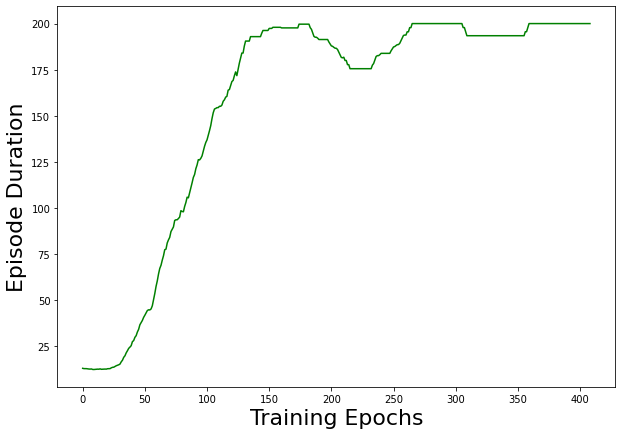

In [13]:
score = np.array(score)
avg_score = running_mean(score, 50)

plt.figure(figsize=(10,7))
plt.ylabel("Episode Duration",fontsize=22)
plt.xlabel("Training Epochs",fontsize=22)
plt.plot(avg_score, color='green')
